## VAE 5.1

conv filts up to 256. LeakyReLU with alpha=.2. lr decay.


### Import Libraries and Dataset

In [1]:
import matplotlib.pyplot as plt #make a bunch of .py files for each architecture 
import numpy as np 
import random
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import os
from torchinfo import summary
import torchvision.utils as vutils
import umap
import glob
import netCDF4 as nc
import plotly.express as px
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import hdbscan

image_size=384

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #sends tensors to GPU
print(f'Selected device: {device}') 

batch_size = 8

Selected device: cuda


### Converting an Image to Tensor

In [2]:
images = '/home/rsankar/zooniverse/projects/junocam/junodata/segments_20220419_384.nc'

### DataLoader Class

In [3]:
class DataGenerator():
    def __init__(self, nc_file, batch_size, indices=None):
        self.nc_file = nc_file

        self.batch_size = batch_size

        if indices is not None:
            self.indices = indices
            self.ndata   = len(indices)
        else:
            with nc.Dataset(nc_file, 'r') as dset:
                self.ndata = int(dset.dimensions['segments'].size)
            self.indices = np.arange(self.ndata)

        print(f"Found data with {self.ndata} images")

    def shuffle(self):
        np.random.shuffle(self.indices)

    def __len__(self):
        return self.ndata // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        with nc.Dataset(self.nc_file, 'r') as dset:
            imgs = dset.variables['imgs'][batch_indices,:,:,:]
        imgs[np.isnan(imgs)] = 0.
        
        imgs= np.transpose(imgs, (0,3,1,2))
        
        #return np.transpose(imgs, (0,3,1,2))
        return torch.Tensor(imgs) #changed this part bc I was getting an error w/ my training fcn

    def get_meta(self, key, index=None):
        if index is not None:
            batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        else:
            batch_indices = self.indices

        with nc.Dataset(self.nc_file, 'r') as dset:
            var = dset.variables[key][batch_indices]

        return var

class NumpyGenerator(DataGenerator):
    def __init__(self, data, batch_size, indices=None):
        self.data  = data
        self.ndata = len(data)

        self.batch_size = batch_size

        if indices is not None:
            self.indices = indices
        else:
            self.indices = np.arange(self.ndata)

    def __getitem__(self, index):
        if index >= self.__len__():
            raise StopIteration

        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        imgs = self.data[batch_indices,:,:,:]

        return imgs


def create_generators(nc_file, batch_size, val_split=0.1):
    with nc.Dataset(nc_file, 'r') as dset:
        ndata = dset.dimensions['segments'].size

    print(f"Loading data with {ndata} images")

    inds = np.arange(ndata)
    np.random.shuffle(inds)

    val_split_ind = int(ndata*val_split)
    val_ind      = inds[:val_split_ind]
    training_ind = inds[val_split_ind:]
    
    train_data = DataGenerator(nc_file, batch_size, indices=training_ind)
    val_data   = DataGenerator(nc_file, batch_size, indices=val_ind)

    return train_data, val_data

In [4]:
training_data, val_data = create_generators(images, batch_size = batch_size)

Loading data with 68322 images
Found data with 61490 images
Found data with 6832 images


In [5]:
len(training_data)

7686

### Notes

### Define Encoder and Decoder

In [6]:
def sample(mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return mu + eps*std

class Encoder(nn.Module): 
    def __init__(self, conv_filt, hidden, input_channels=3): #conv_filt
        super(Encoder, self).__init__()
        
        self.layers = [] 
        
        conv_filts = [16, 32, 64, 128] #list of filters to run through later
        for i in range(2):
            conv_filts.append(conv_filt) #conv_filt=128
            
        #conv_filts = [16, 32, 64, 128, 128, 128]
        
            
        #make layers   
        filt_prev = input_channels #previous number of input channels, starting at 3
        
        for i, filt in enumerate(conv_filts): #prev was padding='valid' (no padding)
            if i==5:
                self.layers.append(nn.Conv2d(filt_prev, filt, 5, stride=1, padding=1)) #in channels, out channels, kernel size
                
            else:
                self.layers.append(nn.Conv2d(filt_prev, filt, 3, stride=1, padding=1)) #in channels, out channels, kernel size
            self.layers.append(nn.LeakyReLU(.2))# alpha parameter
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #stride=1
            self.layers.append(nn.BatchNorm2d(filt))
            filt_prev = filt
            
        nconv = len(hidden) #is hidden [512, 256, 128, encoded_space_dim]?
        
        
        #convolutional in bottleneck instead of flattened
        #runs through each filter in hidden and does a 1x1 convolution
        for i in range(nconv):
            self.layers.append(nn.Conv2d(filt, hidden[i], 1, 1, padding=0)) #filt is 128, so 128->512
            self.layers.append(nn.LeakyReLU(.2)) #Tanh?
            self.layers.append(nn.BatchNorm2d(hidden[i]))
            filt = hidden[i]  #ends at batchnorm(encoded_space_dim)
            
        #self.layers.append(nn.Flatten(start_dim=1))
            
        self.layers = nn.ModuleList(self.layers)
            
    def forward(self, x): #list of encoding + hidden layers
        # run the input through the layers
        for layer in self.layers:
            x = layer(x)
        return x

class Decoder(nn.Module):
    def __init__(self, conv_filt, hidden, input_channels): #input channels = encoded_space_dim?
        super(Decoder, self).__init__()
        self.layers = []
        
        #self.layers.append(nn.Unflatten(dim=1, unflattened_size=(4, 5, 5))) 
        
        filt = input_channels #last layer of hidden- encoded_space_dim 
        #convolutional layers in bottleneck
        nconv = len(hidden) 
        for i in range(nconv):
            self.layers.append(nn.Conv2d(filt, hidden[i], 1, 1, padding=0)) 
            self.layers.append(nn.LeakyReLU(.2))
            self.layers.append(nn.BatchNorm2d(hidden[i]))
            filt = hidden[i]
            
        
        conv_filts = []  
        for i in range(1):
            conv_filts.append(conv_filt)
        conv_filts.extend([128, 64, 32, 16]) 
        
        filt_prev = filt #and filt = final element of hidden = 128
        for i, filt in enumerate(conv_filts): 
            #if i==4:
                #self.layers.append(nn.ConvTranspose2d(filt_prev, filt, 5, stride=2, padding=0))
                #kernel size 5 brings up to 447
            #else:
            self.layers.append(nn.ConvTranspose2d(filt_prev, filt, 3, stride=2, padding=0)) 
            self.layers.append(nn.LeakyReLU(.2))
            self.layers.append(nn.BatchNorm2d(filt))
            filt_prev=filt
  
            #do an if, else, and have if i=0 then kernel size = 5
        self.layers.append(nn.ConvTranspose2d(filt, 3, 5, stride=2, padding=0)) #try kernel 5 instead of upsample
        self.layers.append(nn.LeakyReLU(.2))
        self.layers.append(nn.BatchNorm2d(3))
        #self.layers.append(nn.Upsample((385,385)))
        self.layers.append(nn.Conv2d(3, 3, 2, 1)) 
        
        self.layers = nn.ModuleList(self.layers)
        
        
    def forward(self, x):
        # run the input through the layers
        for layer in self.layers:
            x = layer(x)
        x = torch.sigmoid(x)
        #x = transforms.CenterCrop(size=384)(x)
        return x
    
class BaseVAE(nn.Module):
    def __init__(self, conv_filt, hidden, input_channels=3):
        super(BaseVAE, self).__init__()

        self.conv_filt = conv_filt
        self.hidden    = hidden

        self.conv_mu  = nn.Conv2d(hidden[-1], hidden[-1], 1, 1) #[-1] is last item
        self.conv_sig = nn.Conv2d(hidden[-1], hidden[-1], 1, 1)
        
        self.flat_mu    = nn.Flatten()
        self.flat_sig   = nn.Flatten()

        self.encoder = Encoder(conv_filt, hidden, input_channels)
        self.decoder = Decoder(conv_filt, hidden[::-1], hidden[-1]) #[::-1] is all items, reversed
        #input channels for decoder is last entry of hidden

        self.type = ['VAE']

    def encode(self, x):
        enc = self.encoder(x)
        
        mu      = self.flat_mu(self.conv_mu(enc))
        log_var = self.flat_sig(self.conv_sig(enc))
        z       = sample(mu, log_var)

        return mu, log_var, z

    def decode(self, z):
        dec_inp = torch.reshape(z, (z.shape[0], self.hidden[-1], 5, 5)) #last two numbers are dimensions of img

        dec = self.decoder(dec_inp)

        return dec

    def forward(self, x):
        out = self.decode(self.encode(x)[2])

        return out



### Initialize Loss and Optimizer

In [8]:
def mse_loss(y_true, y_pred):
    mse = torch.mean(torch.sum(torch.abs(y_true - y_pred), axis=(-1, -2)), axis=-1)#square vs abs
    return torch.mean(mse)

def kl_loss(mu, sig, mup, sig0=-4):
    kl = 0.5*torch.mean(-1 - sig + sig0 + (torch.square(mu-mup) + torch.exp(sig))/np.exp(sig0), axis=-1)
    return torch.mean(kl)

def loss_fcn(y_true, y_pred, mu, sig, mup, sig0=-4):
    mse = torch.mean(torch.sum(torch.abs(y_true - y_pred), axis=(-1, -2)), axis=-1)
    kl = 0.5*torch.mean(-1 - sig + sig0 + (torch.square(mu-mup) + torch.exp(sig))/np.exp(sig0), axis=-1)
    total_loss = .9*torch.mean(mse) + .1*torch.mean(kl)
    return total_loss #mup is mu predicted
    

lr = 1e-4 #Define optimizer for both encoder and decoder

torch.manual_seed(0)

encoded_space_dim = 4 #Initialize networks 

h = [128, 64, 32, encoded_space_dim]


vae = BaseVAE(conv_filt=256, hidden= h, input_channels=3)

params_to_optimize = [{'params': vae.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

vae.to(device) #send to GPU

BaseVAE(
  (conv_mu): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv_sig): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
  (flat_mu): Flatten(start_dim=1, end_dim=-1)
  (flat_sig): Flatten(start_dim=1, end_dim=-1)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.2)
      (10): MaxPool2

In [ ]:
summary(vae, [1, 3, 384, 384])

### Train and Evaluate Autoencoder

In [ ]:
def train_epoch(encoder, device, dataloader, loss_fcn, optimizer): #define training fcn
    encoder.train()
    #decoder.train()
    train_loss = []
    mse_epoch_loss = []
    kl_epoch_loss = []
    
    pbar = tqdm.tqdm(dataloader)
    

    
    for batch, image_batch in enumerate(pbar): 
        
        image_batch = image_batch.to(device) #moves tensor to GPU
        
        decoded_data = vae(image_batch) #encode data
       
        #decoded_data = decoder(encoded_data) #decode data
        
        #loss = loss_fcn(decoded_data, image_batch) #evaluate loss
        
        #new loss
        
        mse_train_loss = mse_loss(decoded_data, image_batch)
        
        kl_train_loss = kl_loss(vae.encode(image_batch)[0], vae.encode(image_batch)[1],\
                        vae.encode(vae.forward(image_batch))[0], sig0=-4)
        
        loss = loss_fcn(decoded_data, image_batch, vae.encode(image_batch)[0], vae.encode(image_batch)[1],\
                        vae.encode(vae.forward(image_batch))[0], sig0=-4)
        
    
        
        #vae.forward(image_batch) gives decoded_output. then mup is vae.encode(decoded_output)[0]
     
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        pbar.set_postfix_str('\t loss: %.5f' % (loss.data))
#         train_loss.extend(loss.detach().cpu().numpy().tolist())
#         mse_epoch_loss.extend(mse_train_loss.detach().cpu().numpy().tolist())
#         kl_epoch_loss.extend(kl_train_loss.detach().cpu().numpy().tolist())

        train_loss.append(loss.detach().cpu().numpy().tolist()) #extend?
        mse_epoch_loss.append(mse_train_loss.detach().cpu().numpy())
        kl_epoch_loss.append(kl_train_loss.detach().cpu().numpy())
        training_data.shuffle()
        
        
    return np.mean(train_loss), np.mean(mse_epoch_loss), np.mean(kl_epoch_loss)

In [ ]:
def test_epoch(encoder, device, dataloader, loss_fcn): #define fcn to evaluate performance
    encoder.eval()
    #decoder.eval()
    val_loss = []
    
    with torch.no_grad(): #don't need to track gradients
        
        for image_batch in dataloader:
            
            image_batch = image_batch.to(device)
            
            decoded_data = vae(image_batch)
            
            #decoded_data = decoder(encoded_data)
        
            v_loss = loss_fcn(decoded_data, image_batch, vae.encode(image_batch)[0], vae.encode(image_batch)[1],\
                        vae.encode(vae.forward(image_batch))[0], sig0=-4)
            
            
            #print('\t partial val loss (single batch): %f' % (v_loss.data))
            
            val_loss.append(v_loss.detach().cpu().numpy())
    
    
    
        return np.mean(val_loss)
    

### Train Autoencoder

In [ ]:
num_epochs = 200
diz_loss = {'train_loss':[], 'val_loss':[]}


lr = 1e-4
lr_decay = .95
decay_freq = 5

params_to_optimize = [{'params': vae.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

if lr_decay is not None:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=lr_decay)
else:
    scheduler = None

for epoch in range(num_epochs):
    

    
    train_loss_epoch, mse_train, kl_train = train_epoch(vae, device, training_data, loss_fcn, optim)
   
    val_loss_epoch = test_epoch(vae, device, val_data, loss_fcn)
    
    print('\n EPOCH {}/{} \t train loss {} \t val loss {} \t mse loss {} \t kl loss {} '.format(epoch + 1, num_epochs, train_loss_epoch, val_loss_epoch, mse_train, kl_train))
    diz_loss['train_loss'].append(train_loss_epoch)
    diz_loss['val_loss'].append(val_loss_epoch)
    
    

    if scheduler is not None:
        if (epoch+1)%decay_freq==0:
            lr = scheduler.step()
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
    print(lr)
    
    
    with torch.no_grad():
        
        fig = plt.figure(figsize=(16, 16))
        batch = training_data[0].to(device) #training_data[0] is the first batch of images
        val_batch = val_data[0].to(device)
         
        
        # plot the original images
        ax = plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)
        
        rec_batch = vae.forward((batch)) #puts batch through encoder and decoder
        rec_val = vae.forward((val_batch))
        
        #plot the reconstructed images
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(rec_batch, padding=1, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)
        
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(val_batch, padding=2, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)
        
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(rec_val, padding=1, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)
    

In [ ]:
# savepath = '/home/cnesmi01/vae4.1'

# torch.save(vae.state_dict(), f"{savepath}.pth")
# print(f"saved to {savepath}.pth")

In [9]:
vae.load_state_dict(torch.load('vae5.1.pth'))

<All keys matched successfully>

NameError: name 'diz_loss' is not defined

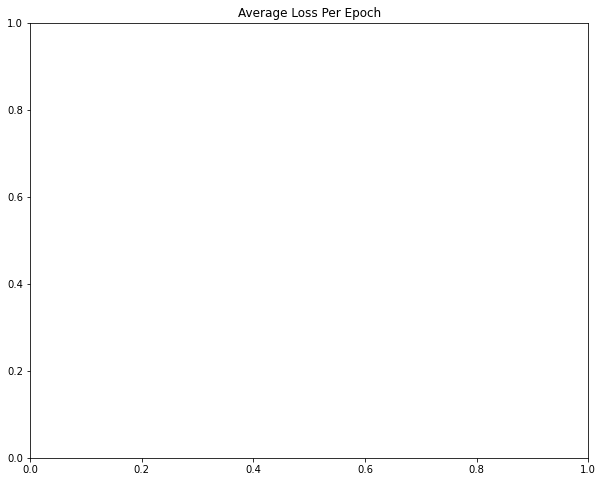

In [43]:
plt.figure(figsize=(10,8))
plt.title('Average Loss Per Epoch')
plt.semilogy(diz_loss['train_loss'], label='Train', color='slateblue')
plt.semilogy(diz_loss['val_loss'], label='Valid', color='hotpink')
plt.plot
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()




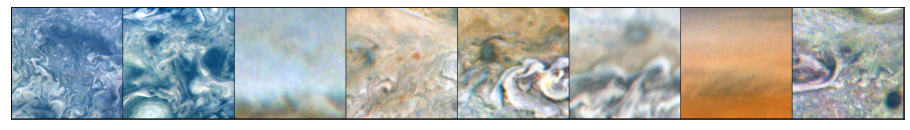

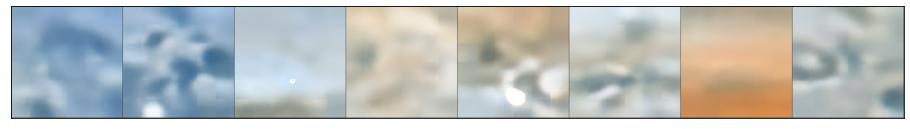

In [10]:
with torch.no_grad():
        
        fig = plt.figure(figsize=(16, 16))
        batch = training_data[0].to(device) #training_data[0] is the first batch of images
        val_batch = val_data[0].to(device)
         
        
        # plot the original images
        ax = plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)
        
        rec_batch = vae.forward((batch)) #puts batch through encoder and decoder
        rec_val = vae.forward((val_batch))
        
        #plot the reconstructed images
        fig = plt.figure(figsize=(16, 16))
        ax = plt.imshow(np.transpose(vutils.make_grid(rec_batch, padding=1, normalize=True).cpu(),(1,2,0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plt.show(fig)

### Generate New Samples

### Visualize Latent Space

In [11]:
encoded_samples = []

for sample_img in tqdm.tqdm(training_data): 
    img = sample_img.to(device)
    label = sample_img[1]
    vae.eval() #encode image
    
    with torch.no_grad():
        encoded_img = vae.encode(img)[2]
        
    encoded_img = encoded_img.cpu().numpy()
    #encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    #encoded_sample['label'] = label
    encoded_samples.extend([encoded_img[i,:] for i in range(len(encoded_img))]) #extend instead of append
    #print(encoded_img.shape): batch size, latent space size
    
#encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples=np.asarray(encoded_samples)
print(encoded_samples.shape)

7687it [04:53, 26.17it/s]                                                       

(61490, 100)


In [12]:
#attempting umap

reducer = umap.UMAP(random_state=1, min_dist=0) #n_components = 3
embedding = reducer.fit_transform(encoded_samples)
embedding.shape

(61490, 2)

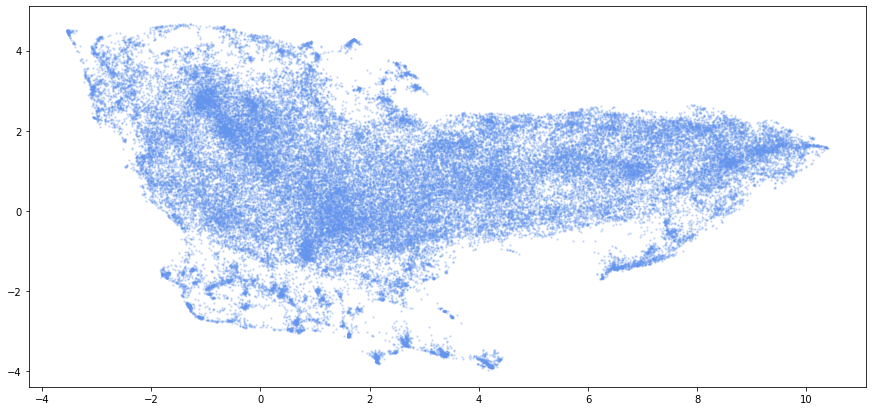

In [13]:
plt.figure(figsize=(15,7))
x = embedding[:, 0]
y = embedding[:, 1]
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s=2, color='cornflowerblue', alpha=.25
)
#plt.title('UMAP of Latent Space, 4 x 5 x 5', fontsize=20)
#plt.scatter(x=1.2, y=-3.935, s=500, alpha=.4, color='hotpink', edgecolors='black', label = 'large white vortices- right side of image')


In [ ]:
fig = px.scatter(x= embedding[:, 0],
    y=embedding[:, 1], opacity=0.7
          )
fig.update_traces(marker={'size': 2})

In [ ]:
mask = (x<5.9)&(x>5.48)&(y<2)&(y>1.5)

In [ ]:
mask_indices = np.where(mask)[0]
print(mask_indices)
len(mask_indices)

In [ ]:
batch_indices = training_data.indices[mask_indices]

with nc.Dataset(training_data.nc_file, 'r') as dset:
    imgs = dset.variables['imgs'][batch_indices,:,:,:]
    
# for img in imgs:
#     plt.figure(figsize=(1,1))
#     plt.imshow(img)
#     plt.show()

0.469865018702228


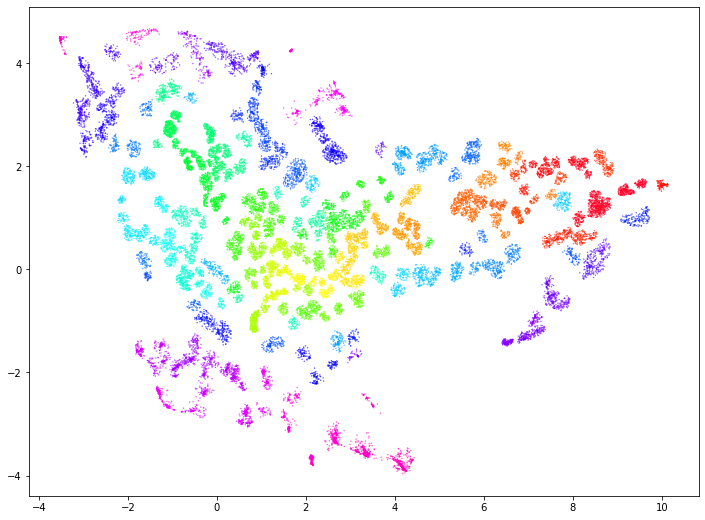

In [14]:
#clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method='leaf').fit(embedding)
clusterer = OPTICS(xi=0.002, max_eps=6, metric='sqeuclidean', min_samples=40).fit(embedding)
#embedding is the name of the umap fit on encoded samples

non_invalid = clusterer.labels_ > -1

print(sum(non_invalid)/len(clusterer.labels_))


plt.figure(figsize=(12,9))
plt.scatter(embedding[non_invalid,0], embedding[non_invalid,1], s=0.1, c=clusterer.labels_[non_invalid], cmap='gist_rainbow')



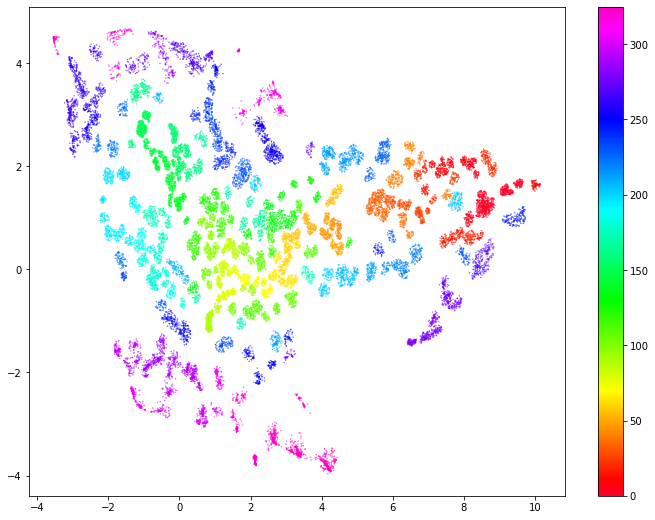

In [15]:
plt.figure(figsize=(12,9))
plt.scatter(embedding[non_invalid,0], embedding[non_invalid,1], 
                  s=0.1, c=clusterer.labels_[non_invalid], cmap='gist_rainbow')
plt.colorbar()

In [16]:
def plot_cluster_images(label):
    inds = np.where(clusterer.labels_==label)[0]
    
    imgs = training_data.get_from_indices(inds) #replace
    
    fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, dpi=150)

    for i in range(20):
        ax1 = axs[i//5, i%5]

    #     i += 30
        ax1.imshow(imgs[i], cmap='gray')

        ax1.axis('off')
    plt.tight_layout()

    fig, ax = plt.subplots(1,1,dpi=150)
    
    cont = ax.scatter(projection[:,0], projection[:,1], 
                      s=0.1, color='gray')

    cont = ax.scatter(projection[inds,0], projection[inds,1], 
                      s=0.1, c=clusterer.labels_[inds], cmap='gist_ncar', vmin=0, vmax=12)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [17]:
plot_cluster_images(0)

AttributeError: 'DataGenerator' object has no attribute 'get_from_indices'